# Importing Module

In [1]:
#kplr used to import koi data easier
import kplr
client = kplr.API()

#used to open .fits files
import pyfits

#Another possible way to plot with interactive plots
from bokeh.plotting import figure, show, output_file,output_notebook
#Allows for viewing of plots on jupyter notebooks
# BOKEH_RESOURCES=inline
# output_notebook()

#For Maximum Likelihood
from scipy import optimize

#Used for scientific computing
import numpy as np

#For making copies of data
import copy

#Needed to correct median with 'nan' data points
import math

#For Periodogram
from gatspy.periodic import LombScargleFast

#Importing and notebook setup
%matplotlib inline

#For Plotting
import matplotlib.pyplot as plt

#adjusting data using pyke
import pyke

#for astro constants
from astropy.constants import *

#needed for bls function
import math

#median
import statistics

#box least square module
import bls

# Making useful functions

Removing "nan" Flux Data Points

In [2]:
###Removes nan data points
def remove_nan(datax,datay):
    #array of nan points location in flux array
    nan_points=np.array([])
    
    #finds points that have nan as data point
    for j in range(0,len(datax)-1):
        if math.isnan(datay[j])==True:
            nan_points = np.append(nan_points,j)
            
    #deletes the points with nan and correspoding time
    datax = np.delete(datax,nan_points)
    datay = np.delete(datay,nan_points)
        
    return(datax,datay)

Median Smooth

In [3]:
### Median Smooth the flux of a star
#time - time data
#flux - flux data
#interval - number of data to smooth over for each step
def median_smooth(time,flux,interval):    
    x = 0
    f_q = copy.copy(flux)
    #removing nan values
    t_q,f_q= remove_nan(time,f_q)
    f_sort=f_q[0:interval]
    
    while x+2< len(f_q)-3:
        f_sort = np.sort(f_q[x:x+interval]) #sort data min to max
        f_median = statistics.median(f_sort) #find median
        if f_q[2+x] > f_median:
            f_q[2+x] = f_median #replace value with median
        x = x+1
    
    return (t_q,f_q)

Periodograms

In [4]:
###Lomb-Scargle Periodogram

# Used to find periodic activity of star 
### Works only if you remove "nan" data points
#datax - time data
#datay - flux data
#min_per - range minimum for finding period
#max_per -  range maximum for finding period
#nyquist -  time between data points
def periodogram(datax, datay, min_per, max_per, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist)
    
    #plotting
    x_label = 'Period'
    y_label = 'Power'
    title = 'Lomb-Scargle Periodogram'
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(period,power)

    # set range and find period
    model.optimizer.period_range=(min_per, max_per)
    period = model.best_period
    print("period = {0}".format(period))
    return period

BLS Function

In [5]:
#### Copying code from: https://ridlow.wordpress.com/category/ipython-notebook/

# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

def func_bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print "Different size of array, t and x"
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print "Error: NB > NBMAX!"
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print "Error: fmin < 1/T"
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low

# Beginning to Look at Data

Importing Data

In [6]:
# Find a KOI.
koi = client.koi(265.01)

#Download the lightcurves for this KOI.
lightcurves = koi.get_light_curves(short_cadence=False)
# for lc in lightcurves:
#     print (lc.filename)
print "Kepler ID ", koi.kepid

Kepler ID  12024120


Getting Like Curve Data

In [7]:
#Loop over the datasets and read in the data.
#Open the FITS data file and return the ``pyfits.HDUList``. This will
#download the file if it isn't already saved locally.
datacol = "PDCSAP_FLUX"
errcol = "PDCSAP_FLUX_ERR"
time, flux, ferr, quality = [], [], [], []
for lc in lightcurves:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        #can also append "SAP_Flux"
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data[datacol])
        ferr.append(hdu_data[errcol])
        quality.append(hdu_data["sap_quality"])

Initial Plot of Data

/usr/lib/pymodules/python2.7/matplotlib/lines.py:503: RuntimeWarning: invalid value encountered in greater_equal
  return np.alltrue(x[1:] - x[0:-1] >= 0)


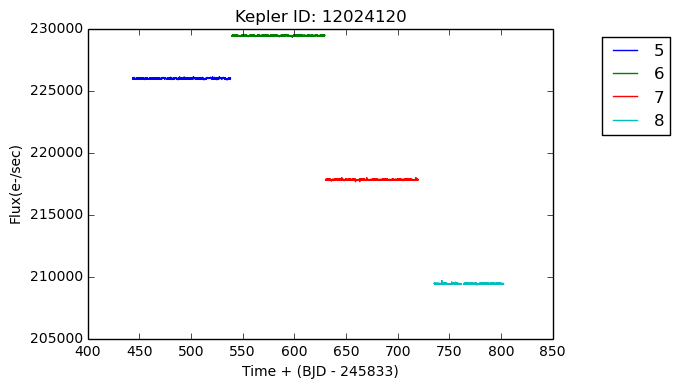

In [8]:
#Time (BJD - 2454833)
#Flux (e-/sec)
q_l = 5
q_h = 8
quarters = np.linspace(q_l,q_h,q_h+1-q_l,dtype=int)
BJD = 245833 #from MAST

#creating labels and title for plot
x_label = 'Time + (BJD - %d)' %BJD
y_label = 'Flux(e-/sec)'
title = 'Kepler ID: %d'%(koi.kepid)


#Creating new plot with title and axis labels for all quarters
plt.figure()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
for x in range (q_l,q_h+1):
#     plt.legend('Quarter %d' % x)
#     print x
    plt.plot(time[x],flux[x],label= x)
    plt.legend(bbox_to_anchor=(1.27, 1))

## Method 1: Detrending Method, Running Average

Step 1: cleaning data, median smoothing to remove outliers

In [9]:
#number of pts smoothing over at each step
interval = 7
#new arrays for smoothed data
fq_median_smooth = []
tq_median_smooth = []

for i in range(q_l,q_h+1):
    t_q,f_q = median_smooth(time[i],flux[i],interval)   
        
    #adding all values for quarter i
    fq_median_smooth.append(f_q)
    tq_median_smooth.append(t_q)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


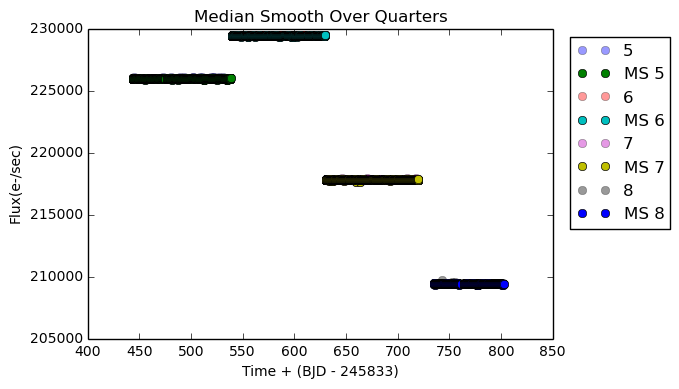

In [10]:
#Setting up plot for Detrending Method
smooth_label = 'Median Smooth Over Quarters'
plt.figure()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(smooth_label)
for x in range(0,len(quarters)):
    q_plt = quarters[x]
    legend = 'MS %d' % q_plt
    
    plt.plot(time[q_plt],flux[q_plt],'o',label=q_plt,alpha= .4)
    plt.plot(tq_median_smooth[x],fq_median_smooth[x],'o',label=legend)
  
plt.legend(bbox_to_anchor=(1.27, 1))
# plt.xlim(400,600)

Step 2: Normalize data

In [57]:
#creating array to hold all normalized fluxes
fq_normalized = []

#Normalizing all Median Smooth Quarters
for i in range(0,len(quarters)):
    median= (len(fq_median_smooth[i]))/2
    f_median = statistics.median(fq_median_smooth[i])
    f_mean = np.mean(fq_median_smooth[i],dtype=np.float64)
    #make changes here if you want running average or median
    fq_normalized.append(fq_median_smooth[i]/f_mean)

#Normalizing all quarters before smoothing
f0_normalized = []
t0_normalized = []
for x in range(q_l,q_h+1):
    time_check,flux_check = remove_nan(time[x],flux[x])
    
    median= (len(flux_check))/2
    f_median = statistics.median(flux_check)
    f_mean = np.mean(flux_check,dtype=np.float64)
    #make changes here if you want running average or median
    f0_normalized.append(flux_check/f_mean)
    t0_normalized.append(time_check)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


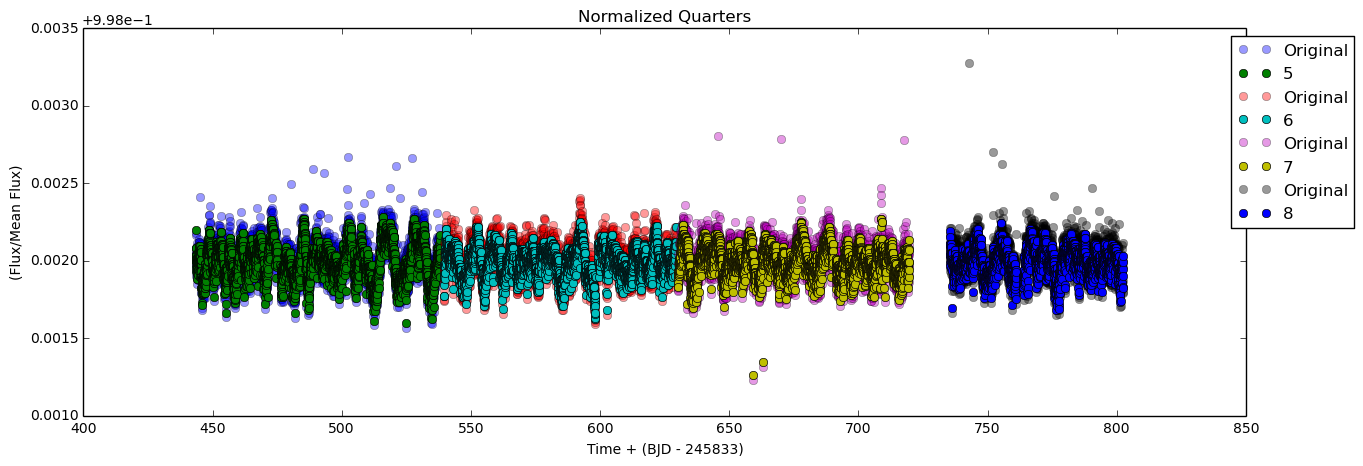

In [62]:
#label and title
normalized_ylabel = '(Flux/Mean Flux)'
normalized_title = 'Normalized Quarters'

#Plotting normalized quarters
plt.figure(figsize=(15,5))
# plt.xlim(110,270)
# plt.ylim(1-.0002,1+.0002)
plt.xlabel(x_label)
plt.ylabel(normalized_ylabel)
plt.title('Normalized Quarters')
#adding x and y data for plot
for x in range(0,len(quarters)):
    q_plt = quarters[x]
    
    plt.plot(t0_normalized[x],f0_normalized[x],'o',label='Original',alpha=.4)
    plt.plot(tq_median_smooth[x],fq_normalized[x],'o',label=q_plt)

plt.legend(bbox_to_anchor=(1.1, 1))

Step 3: Running Average or Median

In [63]:
#combining all quarters into one array
f_normalized = np.hstack(fq_normalized)
t_no_outlier = np.hstack(tq_median_smooth)

#finding the running average interval(needs to be odd number)
npts = int(len(f_normalized))
n = int(np.sqrt(npts))
if int(np.sqrt(npts))%2 ==0:
     n=n+1

In [64]:
c = copy.copy(f_normalized)

#Finding running avg vector
for i in range(0,len(f_normalized)-(n)+1):
    low_r = i #lower range
    high_r = low_r + n #upper range
    center = i + (n+1)/2 #center of interval
    data = f_normalized[low_r:high_r] #interval of data
    running = np.mean(data,dtype=np.float64) #running average
#     running = np.float64( "%f" % np.median(data)) #for running median
    c[center] = running #copying average to first point

In [65]:
#doesn't change the first (n+1)/2 and last (n+1)/2 points
low_r = (n+1)/2 #first point changed 
high_r = len(f_normalized)-low_r #last point changed
f_detrend = (f_normalized[low_r:high_r]/ c[low_r:high_r])#final array has n less points
t_detrend = t_no_outlier[low_r:high_r]#corresponding time 

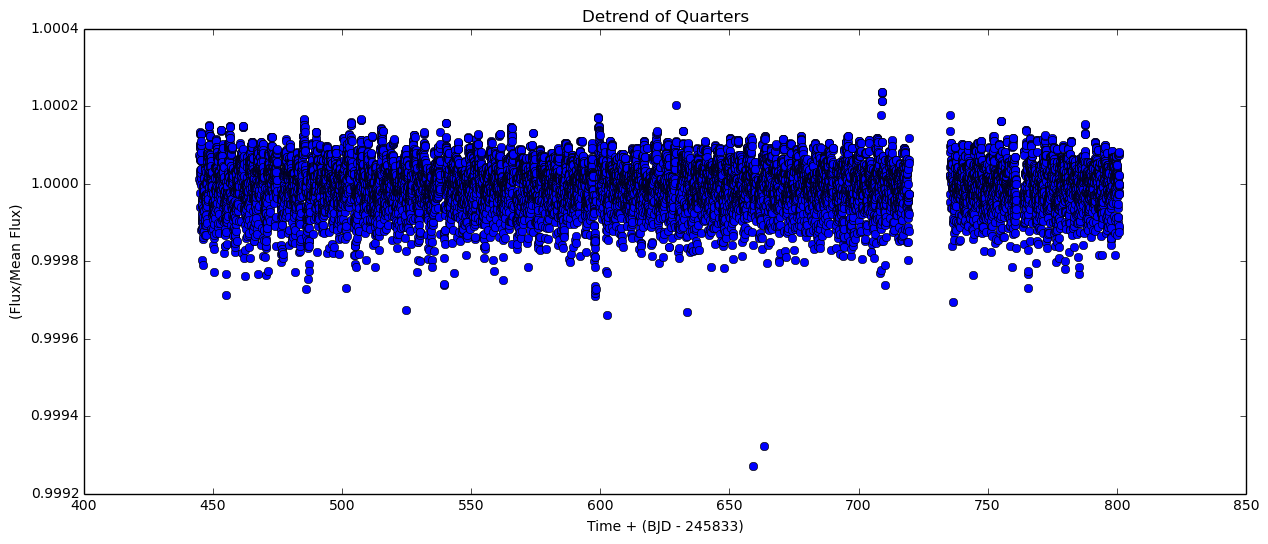

In [66]:
#title for detrend
detrend_title = 'Detrend of Quarters'

#plotting the detrended data
plt.figure(figsize=(15,6))
# plt.xlim(110,270)
# plt.ylim(1-.0002,1+.0002)
plt.title(detrend_title)
plt.xlabel(x_label)
plt.ylabel(normalized_ylabel)

plt.plot(t_detrend,f_detrend,'o')

Step 4: Periodogram and BLS

Finding optimal frequency:
 - Estimated peak width = 0.0176
 - Using 5 steps per peak; omega_step = 0.00353
 - User-specified period range:  0.1 to 32
 - Computing periods at 17753 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 4.1918374504


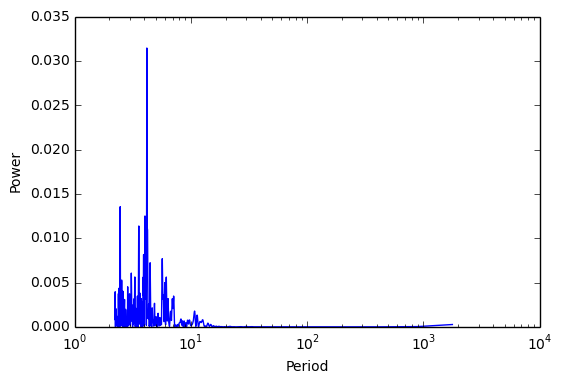

In [67]:
#1st argument: time data
#2nd argument: flux data
#3rd argument: minimum period
#4th argument: max period
#5th argument: time between data points
min_period = .1
max_period = (max(tq_median_smooth[0])-min(tq_median_smooth[0]))/3.
# max_period = 4
nyquist = .02 #30min flux samples
'Median Smooth and Detrend'
period1 = periodogram(t_detrend,f_detrend,min_period,max_period,nyquist)

In [68]:
# t_bls - time is an N-dimensional array of timestamps for the light curve,
# f_bls - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nf is the number of frequency bins to test,
# nb is the number of bins to use in the folded light curve
qmi = 0.06 #.02 is about 30 mins
qma = 0.3
fmin = round(1./max_period,2) #freq = 1/period
# fmin = 1/4.
df = 0.001 
nf = 1000
nb = 200

t_bls = t_detrend
f_bls = f_detrend

# f_bls = np.hstack(f_normalized)
# t_bls = np.hstack(t_median_smooth)
res = func_bls(t_bls, f_bls, qmi, qma, fmin, df, nf, nb)

print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]


print "\ncorrect period: ", 3.568065

Best SR:  9.98697564042e-06 
Ingress:  158 
Egress:  179 
q:  0.109635384037 
Depth:  3.1964997389e-05 
Period:  3.57142857143 
SDE:  6.61540413573

correct period:  3.568065


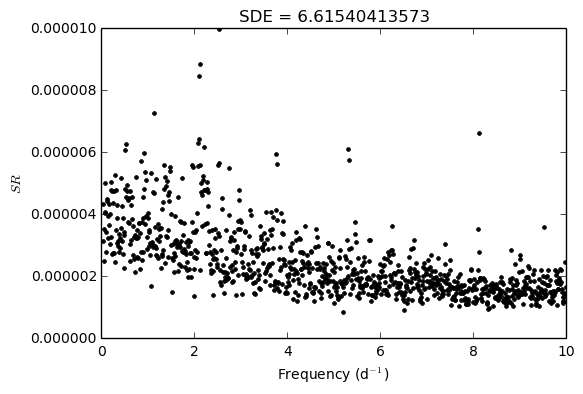

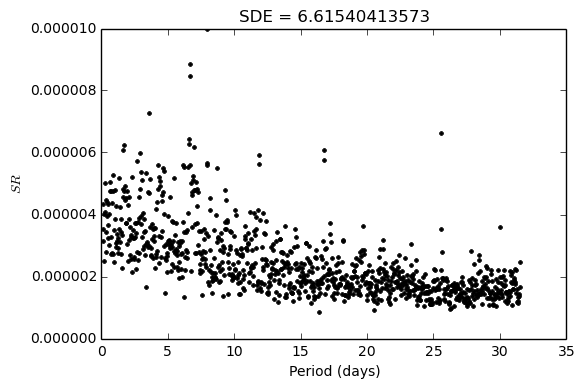

In [69]:
fmax = round(1./min_period,2) #freq = 1/period
steps = (fmax - fmin)/nf
freq = np.arange(fmin, fmax,steps)
steps = (max_period - min_period)/nf
per = np.arange(min_period, max_period,steps)
plt.plot(freq, res[7], 'k.')#res[7]-power
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")
plt.figure()
plt.plot(per, res[7], 'k.')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Period (days)")
plt.ylabel(r"$SR$")


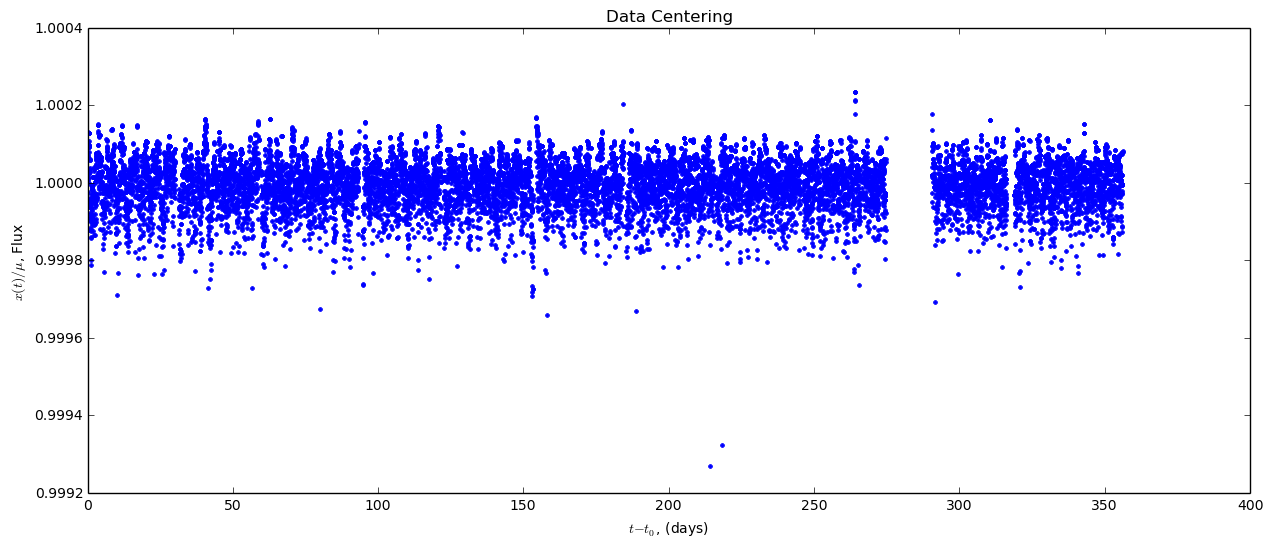

In [70]:
t1 = t_bls[0]
#subtracts t0 from all times
u = t_bls - t1
#avg. flux
s = np.mean(f_bls)

#each flux point subtracted from mean of flux
# v = f_bls - s

## adjustment
#Better cause it shows percentage of change
v = f_bls/s

#plotting data
plt.figure(figsize=(15,6))
plt.plot(u, v, 'b.')
plt.title("Data Centering")
plt.xlabel(r"$t - t_0$, (days)")
plt.ylabel(r"$x(t) / \mu$, Flux")

In [71]:
#converting period to freq
f0 = 1.0/(res[5]) #  freq = 1/T
# f0 = 1.0/3.568065
nbin = nb # number of bin
n = len(t_bls)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(-0.5, 0.5, nbin) 

t_fold = []
#this loop folds the data for each phase
for i in range(n):
    ph = u[i]*f0 #divides by period
    ph = ph - int(ph) # removes integer, ex. 5.2 ->> .2
    
    t_fold.append(ph) #total data time fold
    
    #creates mean value of flux over time in a bin
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in each bin
    y[j] = y[j] + v[i] # sum of light in a bin
    
mean_bin = y/ibi
through_center = np.argmin(mean_bin) #finds index of min of through 
diff_center = nbin/2 - through_center #amount data needs to shift to get centered
mean_bin = np.roll(mean_bin, diff_center) #centers data
t_fold = np.roll(t_fold, -diff_center+11)

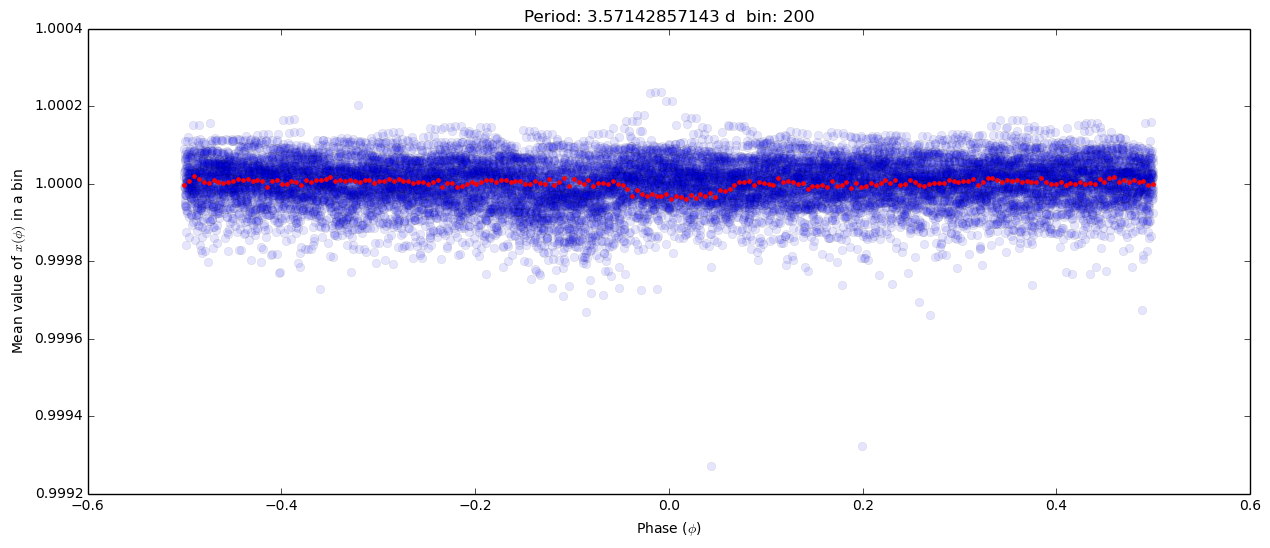

In [72]:
plt.figure(figsize=(15,6))
plt.plot(t_fold-.5,v,'o', alpha=0.1)
plt.plot(phase, mean_bin, 'r.')
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")
# plt.xlim(-.1,.1)
# plt.ylim(1-.0001,1.0001)

depth 3.1964997389e-05


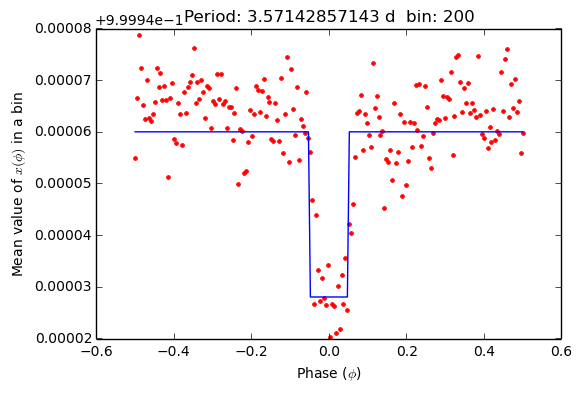

In [73]:
plt.plot(phase, mean_bin, 'r.')

#bls fit
fit = np.ones(nbin) # normalized value
#res[8] = high, res [9] = low
#uses ingress(res[1]), and engress(res[2]), to model expected results
engress = nbin/2 + (res[2] - res[1])/2 # engress bin number
ingress = nbin/2 - (res[2] - res[1])/2 # ingress bin number
fit[ingress:engress] = 1-res[4] #inputting ingress and engress with found depth

print 'depth', res[4]

plt.plot(phase, fit)
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

## Radius of Planet

In [74]:
R_star = 1.35*R_sun # Star we are looking at
# depth = 1-np.abs(trough) #depth of trough
depth = res[4]
R_planet = R_star*np.sqrt(depth) #finding radius of star
print R_planet/R_earth, 'Earth Radii'
print 'True answer: 1.29 Earth Radii'

0.832299166136  Earth Radii
True answer: 1.29 Earth Radii


# Ignore Everything Below Here

In [75]:
import bls

nf = 1000
fmin = round(1./max_period,2) #freq = 1/period
df = 0.001 
nb = 200
qmi = 0.06 #.02 is about 30 mins
qma = 0.3
u = np.empty([1, len(t_bls)])#might be using the wrong array type for u and v
v = np.empty([1, len(f_bls)])

#note: t_detrend and f_detrend are one dimensional arrays

results = bls.eebls(t_bls, f_bls, u, v, nf, fmin, df, nb, qmi, qma)
print 'OLD RESULTS'
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6],

print'\n\nNEW RESULTS'
print 'Best_period:',results[1],'\nBest Power: ',results[2],'\nDepth:',results[3], \
'\nq: ',results[4],'\nin1:',results[5],'\nin2:',results[6]

OLD RESULTS
Best SR:  9.98697564042e-06 
Ingress:  158 
Egress:  179 
q:  0.109635384037 
Depth:  3.1964997389e-05 
Period:  3.57142857143 
SDE:  6.61540413573 

NEW RESULTS
Best_period: 3.57142857143 
Best Power:  9.96866493985e-06 
Depth: 3.19063909082e-05 
q:  0.109635384037 
in1: 159 
in2: 180


In [76]:
R_star = 1.35*R_sun # Star we are looking at
# depth = 1-np.abs(trough) #depth of trough
depth = results[3]
R_planet = R_star*np.sqrt(depth) #finding radius of star
print R_planet/R_earth, 'Earth Radii'
print 'True answer: 1.29 Earth Radii'

0.831535823296  Earth Radii
True answer: 1.29 Earth Radii


In [106]:
from pytransit import MandelAgol
k = R_planet/R_star         #the planet-star radius ratio
t0 = 0.0                    #the transit center
p = results[1]              #the orbital period
a = 10                      #the scaled semi-major axis, in units of star radius
i = 0.5*np.pi              #the orbital inclination
e = 0.01                     #the orbital eccentricity
w = 0.5*np.pi               #the argument of periastron
u = [0.25,0.10]             #contains the quadratic limb darkening coefficients.
t = np.linspace(-0.5,.5,500)#Model time scale

T = .2*results[1]
T_full = T *.5

a = (np.pi/k**.5)*(np.sqrt(T**T_full)/results[1])*(1+e*np.sin(w)/(np.sqrt(1-e**2)))

print a

11.1318098773 


In [107]:
m = MandelAgol()
f = m.evaluate(t, k, u, t0, p, a, i, e, w)

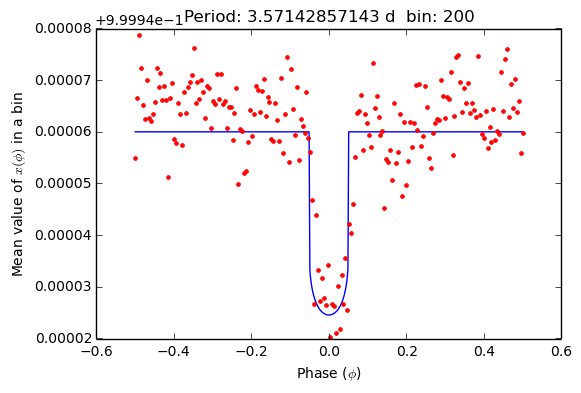

In [108]:
plt.plot(t,f)
plt.plot(phase, mean_bin, 'r.')
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

In [109]:
import batman
print w

1.57079632679


In [110]:
params = batman.TransitParams()
params.t0 = 0                       #time of inferior conjunction
params.per = p                      #orbital period
params.rp = k                      #planet radius (in units of stellar radii)
params.a = a                       #semi-major axis (in units of stellar radii)
params.inc = i                     #orbital inclination (in degrees)
params.ecc = e                      #eccentricity
params.w = w                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]  #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

In [111]:
params = batman.TransitParams()
params.t0 = 0.0                       #time of inferior conjunction
params.per = p                      #orbital period
params.rp = k                      #planet radius (in units of stellar radii)
params.a = a                       #semi-major axis (in units of stellar radii)
params.inc = 90.                  #orbital inclination (in degrees)
params.ecc = e                     #eccentricity
params.w = w                      #longitude of periastron (in degrees)
params.u = u                      #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

m = batman.TransitModel(params, t)    #initializes model
flux_batman = m.light_curve(params)          #calculates light curve

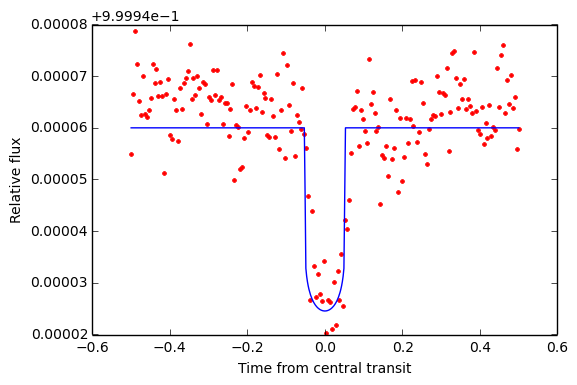

In [112]:
plt.plot(phase, mean_bin, 'r.')
plt.plot(t, flux_batman)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()
